# Illustrating the process of bending paths

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['JAX_ENABLE_X64'] = '1'

cache_path = "../../cache/"

In [2]:
import corc.utils
import corc.graph_metrics.tmm_gmm_neb
import corc.graph_metrics.neb
import corc.tmm_plots
import tqdm
import matplotlib.pyplot as plt

import numpy as np


In [3]:
X,y,_ = corc.utils.load_dataset("noisy_moons", cache_path=cache_path)

In [4]:
tmm_model = corc.graph_metrics.neb.NEB(2,X,y,n_components=15,optimization_iterations=1)
tmm_model.fit(X)

[[90  7]
 [59 15]
 [84 32]
 [48 26]
 [74  3]
 [29 24]
 [43 19]
 [67 32]
 [55 11]
 [58 35]
 [80 16]
 [93 14]
 [61 14]
 [64 23]
 [95 11]]
After filtering 15 components, we are left with 15 components


tmm: 100%|██████████| 150/150 [00:02<00:00, 54.89it/s] 


In [5]:
num_steps = 10
paths_per_step = list()
min_probs = list()
probs = list()
temps = list()
start,finish = (7,8)
# steps = [0,20,40,80,120,300]
steps = [0,40,100,300]

for i in tqdm.tqdm(steps):
    path,temp,prob = corc.graph_metrics.tmm_gmm_neb.compute_interpolation(
        start,
        finish,
        tmm_model.mixture_model.centers,
        tmm_model.mixture_model.covs,
        tmm_model.mixture_model.weights,
        mixture_model="tmm",
        iterations=i
    )
    paths_per_step.append(path)
    min_probs.append(min(prob))
    probs.append(prob)
    temps.append(temp)


100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


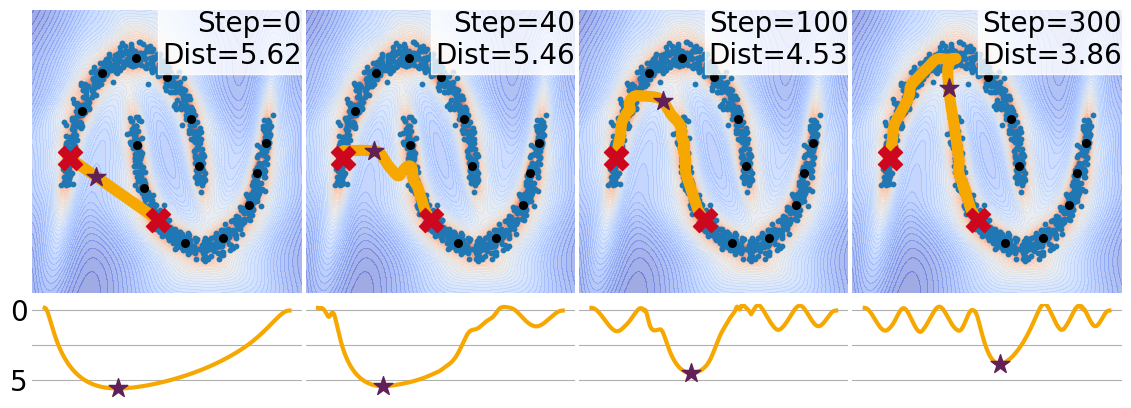

In [31]:
n_cols = 4
fig, axs = plt.subplots(2, n_cols, figsize=(2.8*n_cols,3+1), gridspec_kw={'height_ratios': [3, 1]})
# axs = axs.flatten()

count = 0
for i,ax in enumerate(axs[0]): 
        corc.utils.plot_field(
            data_X=X,
            mixture_model=tmm_model.mixture_model,
            # paths={(5,3):paths_per_step[count]},
            selection=[(5,3)],
            bend_paths=True,
            levels=60,
            axis=ax,
            plot_ids=False,
            grid_resolution=128,
        )
        ax.scatter(
            tmm_model.mixture_model.centers[(start,finish),0],
            tmm_model.mixture_model.centers[(start,finish),1],
            marker="X",
            color="#cc071e",
            alpha=1,
            s=300,
            zorder=100
        )
        ax.axis("off")
        ax.text(
            1,
            1,
            f"Step={steps[count]}\nDist={-min_probs[count]:.2f}",
            horizontalalignment="right",
            verticalalignment="top",
            transform=ax.transAxes,
            fontsize=20,
            bbox={"facecolor": "white", "alpha": 0.8, "pad": 3, "edgecolor": "white"},
        )
        ax.plot(
            paths_per_step[count][:, 0],
            paths_per_step[count][:, 1], 
            lw=8, 
            alpha=1, 
            color="#F6A800",
            zorder=1
        )
        ax.scatter(*paths_per_step[count][np.argmin(probs[count])], c=corc.utils.colors_dict["purple"],zorder=10,s=200, marker="*") 


        count += 1


for i,ax in enumerate(axs[1]):
    ax.plot(temps[i],probs[i],c=corc.utils.colors_dict["orange"],lw=3)
    ax.plot(0.7,-6,c="white") # otherwise the star will be cropped
    ax.set_ylim(axs[1,0].get_ylim())
    ax.scatter(temps[i][np.argmin(probs[i])], np.min(probs[i]), c=corc.utils.colors_dict["purple"],zorder=10, marker="*", s=200) 
    ax.set_yticks([0,-2.5,-5])
    if i>0:
        ax.set_yticklabels([])
        # ax.set_yticks([])
        # ax.get_yaxis().set_visible(False)
    else:
        ax.set_yticklabels(["0","",5])
        # ax.set_ylabel("Dist", fontsize=20)
    # ax.tick_params(axis='y', labelleft=False)
    corc.tmm_plots.remove_border(ax)
    ax.get_xaxis().set_visible(False)
    ax.grid(axis='y')
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='both', which='major', labelsize=20)
# axs[1,0].tick_params(axis='y', labelleft=True)

plt.tight_layout(pad=0.3)
plt.savefig("../../figures/optimization_illustration_main.png", bbox_inches="tight", pad_inches=0,dpi=300)
plt.show()

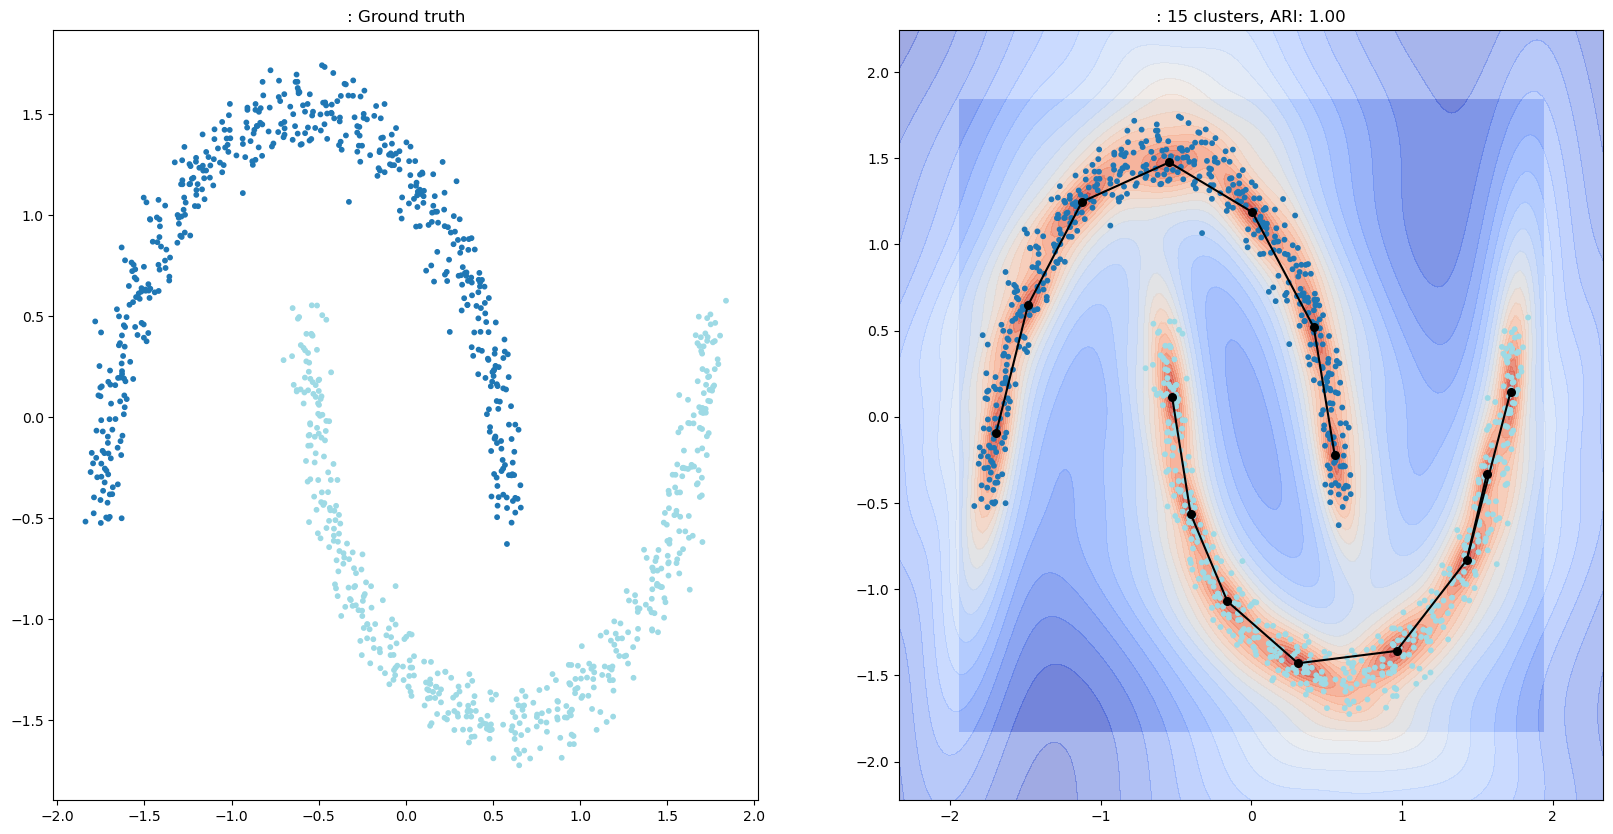

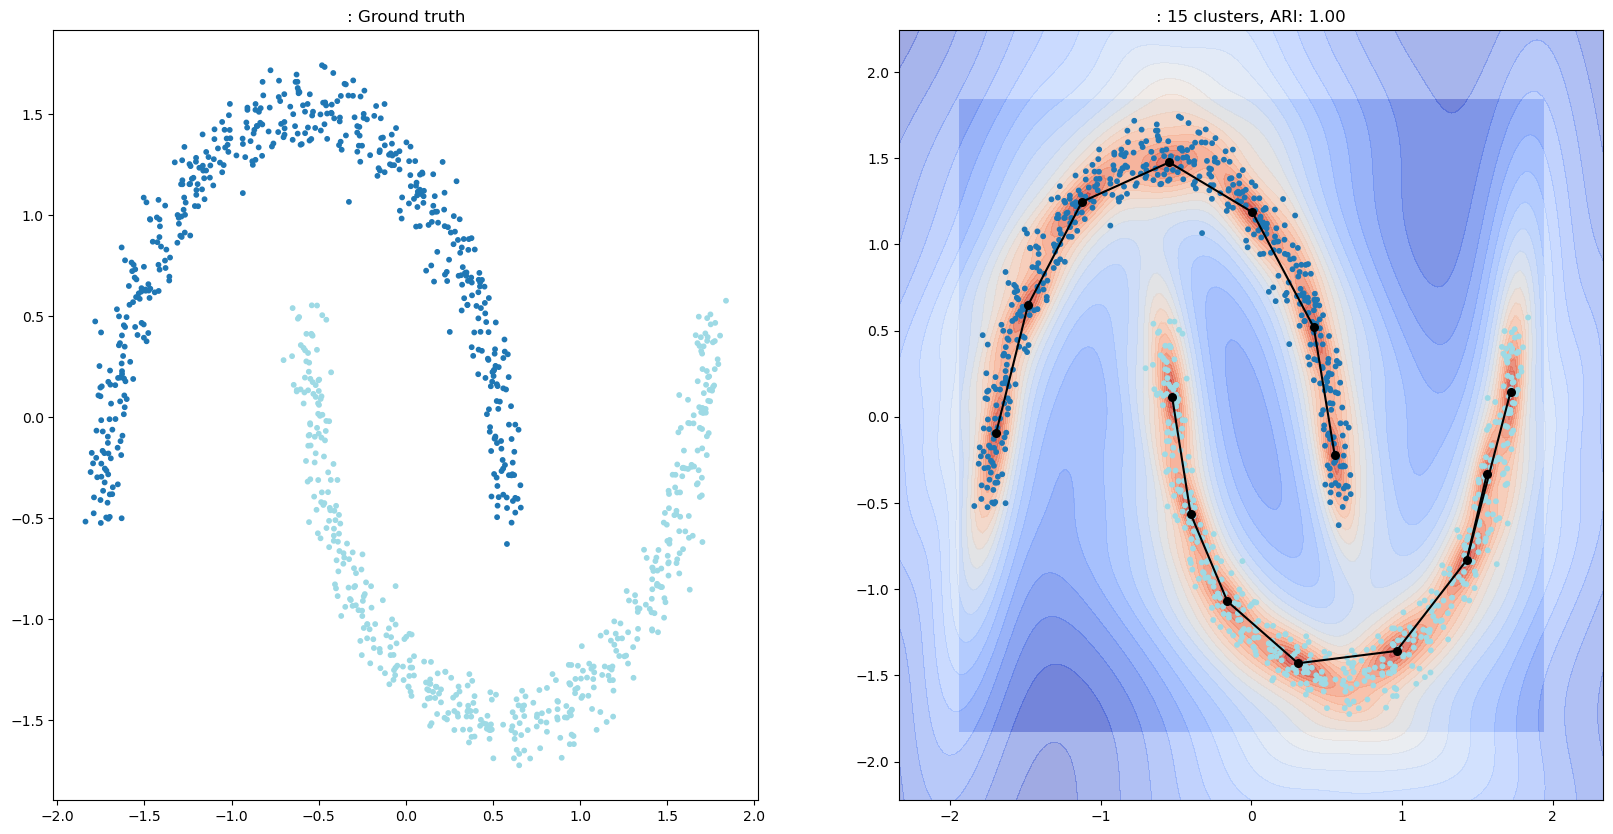

In [11]:
corc.tmm_plots.plot_tmm_models([tmm_model],X,y,"")

In [ ]:
corc.graph_metrics.tmm_gmm_neb.compute_interpolation()